<a href="https://colab.research.google.com/github/vorst4/TUE_5LSM0_g6/blob/master/TUE_5LSM0_g6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0, loss = 2.4247, time = 00:00:00, acc = 19.37, 49/253 correct
	ak     0/0     bcc   22/191   bkl    0/0     df     0/0     
	mel    0/3     nv    27/59    scc    0/0     vasc   0/0     
Iteration 100, loss = 1.4573, time = 00:00:17, acc = 54.94, 139/253 correct
	ak     0/0     bcc   10/35    bkl    9/27    df     0/0     
	mel   20/57    nv   100/134   scc    0/0     vasc   0/0     
Iteration 200, loss = 1.0930, time = 00:00:34, acc = 60.47, 153/253 correct
	ak     0/0     bcc   10/36    bkl    3/6     df     0/0     
	mel   18/35    nv   122/176   scc    0/0     vasc   0/0     
Iteration 300, loss = 0.9433, time = 00:00:51, acc = 62.45, 158/253 correct
	ak     0/0     bcc   16/44    bkl   12/23    df     0/0     
	mel   17/37    nv   113/149   scc    0/0     vasc   0/0     
Iteration 400, loss = 1.0785, time = 00:01:08, acc = 62.45, 158/253 correct
	ak     0/0     bcc   16/45    bkl    4/6     df     0/0     
	mel   14/23    nv   124/179   scc    0/0     vasc   0/0     
Ite

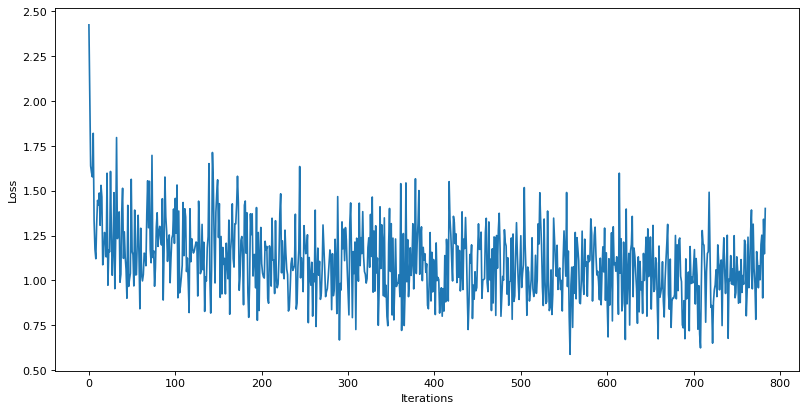

NameError: ignored

In [90]:
# ------------------------------ Import modules ------------------------------ #

import os
import json
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from glob import glob
from datetime import datetime
from PIL import Image
from google.colab import drive


# ----------------------------- Initialize Colab ----------------------------- #
#
# NOTE: all console commands (the ones that start with !) cannot be run from a 
# .py script. Usually this is possible using the command 'os.system('...')'.
# However, in Colab, it is for some reason not possible to obtain the console
# output of the command that is run. This makes it impossible to notify the user
# if an error occurs. All the commands therefore need to be run in the main
# .ipynb script (which is this script).
#

# mount Google Drive (if needed)
if not os.path.exists('drive'):
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('Done')


# setup Git (if needed)
if not os.path.exists('TUE_5LSM0_g6'):
  print('\nSetting up git...')
  print('...Loading github.json from Google Drive')
  with open('/content/drive/My Drive/github.json', 'r') as json_file:
    gitconfig = json.load(json_file)
  print('...Cloning git repo')
  url = 'https://'+gitconfig["username"]+':'+gitconfig["key"]+\
        '@github.com/vorst4/TUE_5LSM0_g6.git'
  !git clone {url}
  print('...Setting username and email')
  !git -C TUE_5LSM0_g6 config user.name {gitconfig["username"]}
  !git -C TUE_5LSM0_g6 config user.email {gitconfig["email"]}
  print('Done')


# check if GPU is enabled
if torch.cuda.is_available() == False:
  raise ValueError('GPU not enabled. Goto runtime -> change runtime type')


# remove default sample_data folder (if needed)
if os.path.exists('sample_data'):
  print('\nRemoving sample_data...')
  os.system('rm -r sample_data')
  print('Done')


# copy and unzip data from Google Drive (if needed)
if not os.path.exists('ISIC_2019_Test_Input'):
  print('\nGetting data...')
  print('...Copying data.zip from Google Drive to workfolder')
  !cp 'drive/My Drive/5LSM0-final-assignment/data.zip' .
  print('...Unpacking data.zip')
  !unzip -q data.zip
  print('...Removing data.zip')
  !rm data.zip
  print('Done\n')


# ----------------------------- Import Functions ----------------------------- #
#
# NOTE: The modules need to be forcibly reloaded because Colab does not do this
# by default, even if the module has changed.
#

# dataloaders
import TUE_5LSM0_g6.dataloaders
importlib.reload(TUE_5LSM0_g6.dataloaders)
dataloaders = TUE_5LSM0_g6.dataloaders.dataloaders

# train & accuracy
import TUE_5LSM0_g6.train
importlib.reload(TUE_5LSM0_g6.train)
train = TUE_5LSM0_g6.train.train
accuracy = TUE_5LSM0_g6.train.accuracy

# resnet18
import TUE_5LSM0_g6.resnet18
importlib.reload(TUE_5LSM0_g6.resnet18)
resnet18 = TUE_5LSM0_g6.resnet18.resnet18


# --------------------------------- Settings --------------------------------- #

# settings object
S = type('settings', (), {})()

# use gpu
S.device = torch.device('cuda')

# set variable type
S.dtype = torch.float32

# when to print
S.print_every = 100

# number of epochs to run
S.epochs = 1

# batch size, increase this until the RAM is full
S.batch_size = 32 # 128 -> ~200 iterations = 1 epoch

# percentage of original train set that is to be used for validation
S.val_ratio = 1

# restore last backup of model?
S.load_backup = False

# Create backup each epoch?
S.backup_each_epoch = False

# Create backup if training is finished?
S.backup_on_finish = False


# ----------------------------------- Main ----------------------------------- #

# create data loader objects for train, validation and test set.
dl_train, dl_val, dl_test = dataloaders(batch_size=S.batch_size,
                                        val_ratio = S.val_ratio)

# learning rate (with decay)
# todo: make a script that runs the model with different rates
learning_rate = 1e-4
decayRate = 0.99

# model
model = resnet18()

# load backup
if S.load_backup:
  model.restore_latest()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
lr_exp = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# train
train(model, optimizer, dl_train, dl_val, lr_exp, S)

# visualize results
model.visualize()

# save obtained model
if S.backup_on_finish:
  model.backup_to_drive()

# get accuracy best model
best_model = model
accuracy(dl_test, best_model)

# create csv file of test data
make_csv(best_model)


# ----------------------------------- End ------------------------------------ #


In [45]:
# ------------------------- GIT Pull, Commit & Push -------------------------- #

def git():

  if not input('\nPull? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 pull

  commit_msg = '\''+input('\nEnter commit message: ')+'\''

  if not input('\nCommit? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 add .
  !git -C /content/TUE_5LSM0_g6 commit -m {commit_msg}

  if not input('\nPush? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 push

git()

# ----------------------------------- End ------------------------------------ #



Pull? (y)y
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/vorst4/TUE_5LSM0_g6
   bfaba9c..6d8e994  master     -> origin/master
Updating bfaba9c..6d8e994
Fast-forward
 TUE_5LSM0_g6.ipynb | 73 ++++++++++++++++++++++++++++++++----------------------
 1 file changed, 44 insertions(+), 29 deletions(-)

Enter commit message: -

Commit? (y)y
[master 933c0cc] -
 1 file changed, 12 insertions(+), 1 deletion(-)

Push? (y)y
Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 512 bytes | 512.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/vorst4/TUE_5LSM0_g6.git
   6d8e994..933c0cc  master -> master
